# RFM分析

In [1]:
# ライブラリの読み込み
import pandas as pd
import matplotlib.pyplot
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# ファイルの読み込み
df = pd.read_csv('buying.csv', encoding="SHIFT-JIS")
df.head()

,id,date,category,price
0,1000,2016/1/8,子供服,500
1,1000,2016/1/8,子供服,4900
2,1000,2016/1/8,収納,10900
3,1000,2016/1/8,女ファッション,300
4,1000,2016/1/8,女パンツ,2500


In [3]:
# データの型確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 4 columns):
id          945 non-null int64
date        945 non-null object
category    945 non-null object
price       945 non-null int64
dtypes: int64(2), object(2)
memory usage: 29.7+ KB


4行945列のデータ

id:各ユーザに割り当てられた番号

date:購入した年月日

category:購入した商品の種類

price:購入した商品の金額

In [4]:
# データの型変換
df['date'] = pd.to_datetime(df['date']) # 日付データを日付型に変換
df['id'] = df['id'].astype(str) # idデータを文字型に変換
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 4 columns):
id          945 non-null object
date        945 non-null datetime64[ns]
category    945 non-null object
price       945 non-null int64
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 29.7+ KB


In [5]:
# 経過日数を計算するための基準日を設定する（今回はデータの最終購入日である2016/02/01に指定します）
NOW = dt.datetime(2016,4,21)
print(NOW)

2016-04-21 00:00:00


In [6]:
# R、F、Mの各値をユーザ毎に集計する
import numpy as np
buying = df.groupby('id').agg({'date': lambda x: (NOW - x.max()).days, # Recency（各ユーザの最終購入日から基準日までの経過日数）
                                'category': [len], # Frequency（各ユーザの購入回数）
                                'price': [np.sum]  # Monetary Value（各ユーザの合計金額）
                              }) 

In [7]:
# カラム名の表示
buying.columns

MultiIndex([(    'date', '<lambda>'),
            ('category',      'len'),
            (   'price',      'sum')],
           )

In [8]:
# カラム名を変更する
buying.columns = ['recency', 'frequency', 'monetary']
# カラム名が変更できたか確認
buying.columns

Index(['recency', 'frequency', 'monetary'], dtype='object')

In [18]:
# R、F、Mのそれぞれについて４段階でスコア付けをする関数を定義（１が高評価で４が低評価）
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    print(f)
    return series.rank(pct=1).apply(f)

上記関数の説明
https://ja.coder.work/so/python/1246284

In [19]:
# Recency
buying['rec_dec'] = pct_rank_qcut(buying['recency'], 4)

# Frequency（数が大きなものを1、小さなものを4とランク付け）
freq_dec = pct_rank_qcut(buying['frequency'], 4)
buying['freq_dec'] = 5 - freq_dec

# Monetary（数が大きなものを1、小さなものを4とランク付け）
mv_dec = pct_rank_qcut(buying['monetary'], 4)
buying['mv_dec'] = 5 - mv_dec

# R,F,Mの3つを組み合わせて、RFMスコアを作成
buying['RFMClass'] = buying.rec_dec.map(str) + buying.freq_dec.map(str) + buying.mv_dec.map(str)

buying.head()

<function pct_rank_qcut.<locals>.<lambda> at 0x000001BC8DE24C80>
<function pct_rank_qcut.<locals>.<lambda> at 0x000001BC8DE24C80>
<function pct_rank_qcut.<locals>.<lambda> at 0x000001BC8DE24C80>


C:\Users\Nakai.Tomoki\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  after removing the cwd from sys.path.


,recency,frequency,monetary,rec_dec,freq_dec,mv_dec,RFMClass
id,,,,,,,
1000,21,12,33500,1,1,1,111
1001,45,2,7600,2,3,2,232
1002,41,1,4800,2,4,3,243
1003,91,1,10000,4,4,2,442
1004,103,2,3100,4,3,4,434


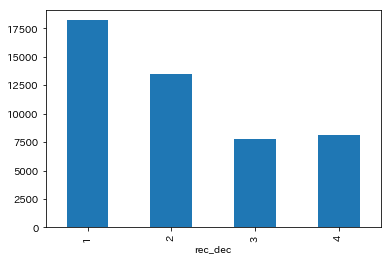

In [14]:
# Recencyの4つのグループにつき、購入金額の平均を比較
rec_dec_m = buying.groupby(['rec_dec'])['monetary'].mean()
rec_dec_m.plot(kind='bar')

↑Recencyに対するチャート（縦軸：購入金額の平均）

知見：最終購入日が基準日に近いユーザの方が1回の買い物での購入金額が多い

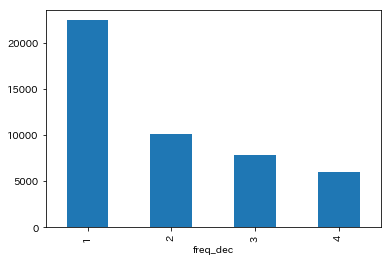

In [15]:
# Frequencyの4つのグループにつき、購入金額の平均を比較
freq_dec_m = buying.groupby(['freq_dec'])['monetary'].mean()
freq_dec_m.plot(kind='bar')

↑Frequencyに対するチャート（縦軸：購入金額の平均）

知見：購入回数が多いユーザの方が1回の買い物での購入金額が多い

追記：buyingデータが手元にないためこれ以上作業を進めることができません（2020/3/27）

参考サイト：http://nami3373.hatenablog.com/entry/2016/09/19/234525